### Importing all the necessary libraries

In [1]:
import requests
import pandas as pd
from io import StringIO
import os
import pymongo
from pymongo import MongoClient
from pandas import json_normalize
import json
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify the folder path where you want to save the Data
file_name = "NCHS_-_Drug_Poisoning_Mortality_by_State__United_States.csv"

### Making the Directory Global

In [3]:
#To ensure your code is portable and the specified folder is accessible on any system,we are using
#environment variables and the Python os module to dynamically create paths based on the 
#user's system environment and creating the folder if not exist
# Getting the desktop directory
desktop_path = os.path.join(os.path.expanduser("~"), 'Desktop')
new_folder_path = os.path.join(desktop_path, 'DAP Project_teamSNS')
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
file_path = os.path.join(new_folder_path, file_name)
print(f"Directory created at: {new_folder_path}")
print(f"File path: {file_path}")

Directory created at: C:\Users\sanju\Desktop\DAP Project_teamSNS
File path: C:\Users\sanju\Desktop\DAP Project_teamSNS\NCHS_-_Drug_Poisoning_Mortality_by_State__United_States.csv


### Extracting dataset through API

In [4]:
#Firstly we are Going to Extract our dataset through API
# URL to fetch CSV data
url = 'https://data.cdc.gov/api/views/44rk-q6r2/rows.csv?accessType=DOWNLOAD'
# Make the GET request
response = requests.get(url)
print(response)
if response.status_code == 200:
    csv_data = StringIO(response.text)
    # Load data into a pandas DataFrame from the file-like object
    df = pd.read_csv(csv_data)
    # Save the DataFrame to CSV in the specified folder
    df.to_csv(file_path, index=False)
    print(f"Data saved to CSV file at: {file_path}")
else:
    print("Failed to retrieve data. Status code:", response.status_code)
print("NCHS_-_Drug_Poisoning_Mortality_by_State__United_States CSV DONE")

<Response [200]>
Data saved to CSV file at: C:\Users\sanju\Desktop\DAP Project_teamSNS\NCHS_-_Drug_Poisoning_Mortality_by_State__United_States.csv
NCHS_-_Drug_Poisoning_Mortality_by_State__United_States CSV DONE


### Converting CSV into JSON

In [5]:
# Dataset names for CSV and JSON files
datasets = ["NCHS_-_Drug_Poisoning_Mortality_by_State__United_States"]
def convert_and_cleanup(data_name):
    csv_file_path = f"{new_folder_path}\\{data_name}.csv"
    json_file_path = f"{new_folder_path}\\{data_name}.json"
    try:
        # Load CSV into DataFrame
        df = pd.read_csv(csv_file_path)
        # Convert DataFrame to JSON
        df.to_json(json_file_path, orient='records', lines=True)
        # Remove the original CSV file
        os.remove(csv_file_path)
        print(f"Converted {csv_file_path} to JSON and deleted the CSV file.")
    except Exception as e:
        print(f"An error occurred processing {data_name}: {e}")
for dataset in datasets:
    convert_and_cleanup(dataset)

Converted C:\Users\sanju\Desktop\DAP Project_teamSNS\NCHS_-_Drug_Poisoning_Mortality_by_State__United_States.csv to JSON and deleted the CSV file.


### Dumping the JSON File in Mongodb database

In [6]:
# MongoDB connection
myclient = pymongo.MongoClient("mongodb://localhost:27017")
db = myclient['DAP']  # DAP is the name of the database
# File paths
Drug_Poisoning_Data = f"{new_folder_path}\\NCHS_-_Drug_Poisoning_Mortality_by_State__United_States.json"
# Inserting JSON data into MongoDB
try:
    collection1 = db.Drug_Poisoning_Data
# Delete existing data in the collection
    collection1.delete_many({})
    print("Existing data deleted from the collection1.")
    with open(Drug_Poisoning_Data, 'r', encoding='utf-8') as file:
        for line in file:
            obj = json.loads(line)  # Parse the JSON data from a line
            collection1.insert_one(obj)
    print("Drug_Poisoning_Data data successfully inserted into MongoDB.")
except Exception as e:
    print("An error occurred while inserting JSON data:", e)

Existing data deleted from the collection1.
Drug_Poisoning_Data data successfully inserted into MongoDB.


### Extracting data from mongodb into Dataframe

In [7]:
client = MongoClient()
#point the client at mongo URI
client = MongoClient('mongodb://localhost:27017')
#select database
db = client['DAP']
#select collection
test = db.Drug_Poisoning_Data
#convert entire collection to pandas Dataframe
test =list(test.find())
df = json_normalize(test)
df.head() # displaying the first 5 data

,_id,State,Year,Sex,Age Group,Race and Hispanic Origin,Deaths,Population,Crude Death Rate,Standard Error for Crude Rate,Low Confidence Limit for Crude Rate,Upper Confidence Limit for Crude Rate,Age-adjusted Rate,Standard Error Age-adjusted Rate,Lower Confidence Limit for Age-adjusted Rate,Upper Confidence for Age-adjusted Rate,State Crude Rate in Range,US Crude Rate,US Age-adjusted Rate,Unit
0,66316916e280327185fac30e,United States,2003,Both Sexes,15–24,Hispanic,226,7255772,3.1148,0.20719,2.7087,3.5209,NaN,NaN,NaN,NaN,None,8.8881,8.8765,"per 100,000 population"
1,66316916e280327185fac30f,Alabama,1999,Both Sexes,All Ages,All Races-All Origins,169,4430143,3.8148,0.29344,3.2396,4.3899,3.8521,0.29657,3.2708,4.4334,1.8–7.5,6.0382,6.0570,"per 100,000 population"
2,66316916e280327185fac310,Alabama,2000,Both Sexes,All Ages,All Races-All Origins,197,4447100,4.4299,0.31561,3.8112,5.0485,4.4857,0.31985,3.8588,5.1126,1.8–7.5,6.1882,6.1749,"per 100,000 population"
3,66316916e280327185fac311,Alabama,2001,Both Sexes,All Ages,All Races-All Origins,216,4467634,4.8348,0.32896,4.1900,5.4795,4.8915,0.33329,4.2382,5.5447,1.8–7.5,6.8057,6.7922,"per 100,000 population"
4,66316916e280327185fac312,Alabama,2002,Both Sexes,All Ages,All Races-All Origins,211,4480089,4.7097,0.32423,4.0742,5.3452,4.7619,0.32868,4.1177,5.4062,1.8–7.5,8.1766,8.1957,"per 100,000 population"


In [8]:
#displaying the last 5 data
df.tail()

,_id,State,Year,Sex,Age Group,Race and Hispanic Origin,Deaths,Population,Crude Death Rate,Standard Error for Crude Rate,Low Confidence Limit for Crude Rate,Upper Confidence Limit for Crude Rate,Age-adjusted Rate,Standard Error Age-adjusted Rate,Lower Confidence Limit for Age-adjusted Rate,Upper Confidence for Age-adjusted Rate,State Crude Rate in Range,US Crude Rate,US Age-adjusted Rate,Unit
3175,66316917e280327185facf75,Wyoming,2014,Both Sexes,All Ages,All Races-All Origins,109,584153,18.6595,1.78726,15.1565,22.1625,19.3823,1.90026,15.6577,23.1068,17.5–57.8,14.7574,14.6831,"per 100,000 population"
3176,66316917e280327185facf76,Wyoming,2015,Both Sexes,All Ages,All Races-All Origins,96,586107,16.3793,1.67170,13.2673,20.0019,16.4454,1.72940,13.2241,20.2142,13.1–17.5,16.3040,16.2923,"per 100,000 population"
3177,66316917e280327185facf77,Wyoming,2016,Both Sexes,All Ages,All Races-All Origins,99,585501,16.9086,1.69938,13.7425,20.5856,17.5871,1.81892,14.1950,21.5453,17.5–57.8,19.6925,19.7851,"per 100,000 population"
3178,66316917e280327185facf78,Wyoming,2017,Both Sexes,All Ages,All Races-All Origins,69,579315,11.9106,1.43387,9.2672,15.0737,12.2040,1.51336,9.4188,15.5550,10.7–13,21.5637,21.7048,"per 100,000 population"
3179,66316917e280327185facf79,Wyoming,2018,Both Sexes,All Ages,All Races-All Origins,66,577737,11.4239,1.40618,8.8352,14.5340,11.0936,1.40936,8.5054,14.2215,10.7–13,20.5910,20.7112,"per 100,000 population"


In [9]:
#Showing data infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   _id                                           3180 non-null   object 
 1   State                                         3180 non-null   object 
 2   Year                                          3180 non-null   int64  
 3   Sex                                           3180 non-null   object 
 4   Age Group                                     3180 non-null   object 
 5   Race and Hispanic Origin                      3180 non-null   object 
 6   Deaths                                        3180 non-null   int64  
 7   Population                                    3180 non-null   int64  
 8   Crude Death Rate                              3180 non-null   float64
 9   Standard Error for Crude Rate                 3180 non-null   f

In [10]:
#Checking for Dupliactes
df.nunique()

_id                                             3180
State                                             52
Year                                              20
Sex                                                3
Age Group                                          9
Race and Hispanic Origin                           4
Deaths                                          1768
Population                                      3179
Crude Death Rate                                3157
Standard Error for Crude Rate                   3129
Low Confidence Limit for Crude Rate             3148
Upper Confidence Limit for Crude Rate           3154
Age-adjusted Rate                               1260
Standard Error Age-adjusted Rate                1256
Lower Confidence Limit for Age-adjusted Rate    1254
Upper Confidence for Age-adjusted Rate          1258
State Crude Rate in Range                         59
US Crude Rate                                     20
US Age-adjusted Rate                          

In [11]:
#Missing Values Calculation
df.isnull().sum()

_id                                                0
State                                              0
Year                                               0
Sex                                                0
Age Group                                          0
Race and Hispanic Origin                           0
Deaths                                             0
Population                                         0
Crude Death Rate                                   0
Standard Error for Crude Rate                      0
Low Confidence Limit for Crude Rate                0
Upper Confidence Limit for Crude Rate              0
Age-adjusted Rate                               1920
Standard Error Age-adjusted Rate                1920
Lower Confidence Limit for Age-adjusted Rate    1920
Upper Confidence for Age-adjusted Rate          1920
State Crude Rate in Range                       1920
US Crude Rate                                      0
US Age-adjusted Rate                          

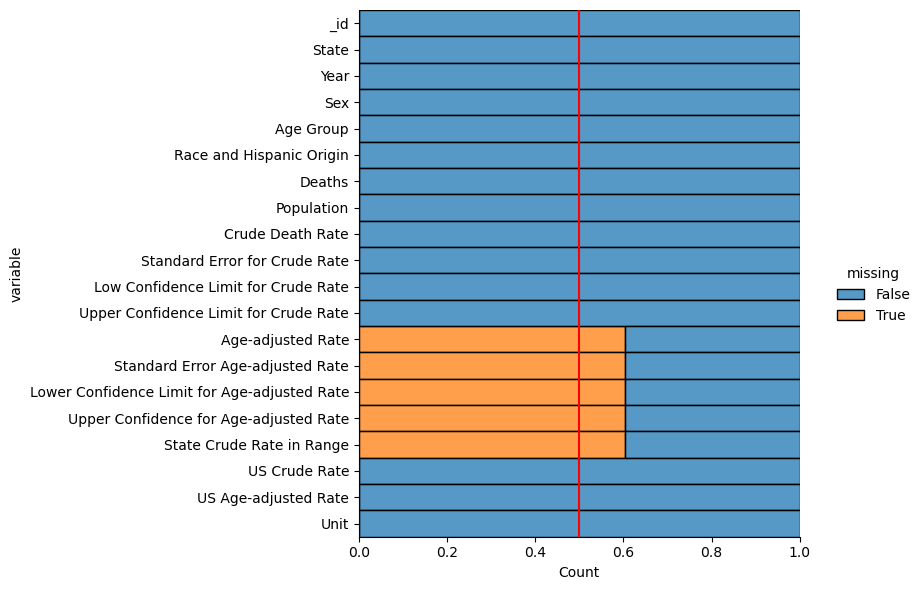

In [12]:
#idengifying null value by visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data=df.isnull().melt(value_name='missing'),y='variable',hue='missing',multiple='fill',height=6,aspect=1.4)
plt.axvline(0.5, color='r')

In [13]:
#Calculating the percentage of missing values
(df.isnull().sum()/(len(df)))*100

_id                                              0.000000
State                                            0.000000
Year                                             0.000000
Sex                                              0.000000
Age Group                                        0.000000
Race and Hispanic Origin                         0.000000
Deaths                                           0.000000
Population                                       0.000000
Crude Death Rate                                 0.000000
Standard Error for Crude Rate                    0.000000
Low Confidence Limit for Crude Rate              0.000000
Upper Confidence Limit for Crude Rate            0.000000
Age-adjusted Rate                               60.377358
Standard Error Age-adjusted Rate                60.377358
Lower Confidence Limit for Age-adjusted Rate    60.377358
Upper Confidence for Age-adjusted Rate          60.377358
State Crude Rate in Range                       60.377358
US Crude Rate 

In [14]:
new_df=df.drop(['_id','Standard Error for Crude Rate','Low Confidence Limit for Crude Rate','Upper Confidence Limit for Crude Rate'
                ,'Standard Error Age-adjusted Rate','Standard Error Age-adjusted Rate'
                , 'Lower Confidence Limit for Age-adjusted Rate','Upper Confidence for Age-adjusted Rate'
                ,'State Crude Rate in Range','Unit'],axis=1)

In [15]:
new_df.head()

,State,Year,Sex,Age Group,Race and Hispanic Origin,Deaths,Population,Crude Death Rate,Age-adjusted Rate,US Crude Rate,US Age-adjusted Rate
0,United States,2003,Both Sexes,15–24,Hispanic,226,7255772,3.1148,NaN,8.8881,8.8765
1,Alabama,1999,Both Sexes,All Ages,All Races-All Origins,169,4430143,3.8148,3.8521,6.0382,6.0570
2,Alabama,2000,Both Sexes,All Ages,All Races-All Origins,197,4447100,4.4299,4.4857,6.1882,6.1749
3,Alabama,2001,Both Sexes,All Ages,All Races-All Origins,216,4467634,4.8348,4.8915,6.8057,6.7922
4,Alabama,2002,Both Sexes,All Ages,All Races-All Origins,211,4480089,4.7097,4.7619,8.1766,8.1957


In [16]:
new_df['Age Group'].unique()

array(['15–24', 'All Ages', '0–14', '25–34', '35–44', '45–54', '55–64',
       '65–74', '75+'], dtype=object)

In [17]:
new_df['Sex'].unique()

array(['Both Sexes', 'Female', 'Male'], dtype=object)

In [18]:
vdf= new_df

In [19]:
#Showing graph of death over a year
data = new_df
# Filter the data for the United States only and for age-adjusted rates
us_data = data[(data['State'] == 'United States') & (data['Age-adjusted Rate'].notnull())]
pivot_data = us_data.pivot_table(
    index='Year', 
    columns='Sex', 
    values='Age-adjusted Rate',
    aggfunc='mean'
).loc[1999:2019]
pivot_data.reset_index(inplace=True)
pivot_data.head()

Sex,Year,Both Sexes,Female,Male
0,1999,6.292375,3.596325,9.079500
1,2000,6.152325,3.692675,8.727925
2,2001,6.557500,4.120000,9.092350
3,2002,7.729100,5.088250,10.472950
4,2003,8.230600,5.515825,11.065625


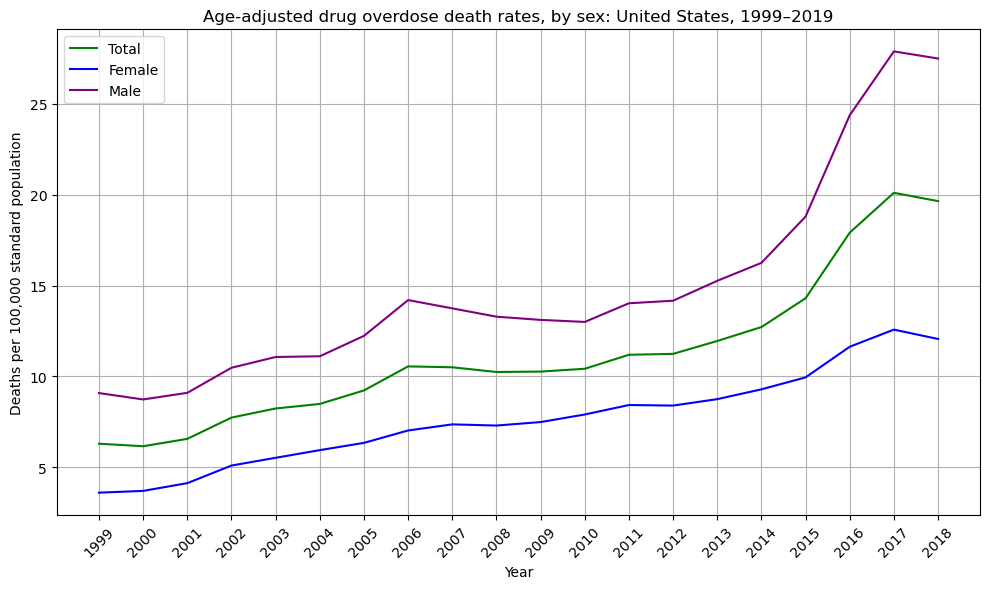

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot each sex
plt.plot(pivot_data['Year'], pivot_data['Both Sexes'], label='Total', color='green')
plt.plot(pivot_data['Year'], pivot_data['Female'], label='Female', color='blue')
plt.plot(pivot_data['Year'], pivot_data['Male'], label='Male', color='purple')
plt.title('Age-adjusted drug overdose death rates, by sex: United States, 1999–2019')
plt.xlabel('Year')
plt.ylabel('Deaths per 100,000 standard population')
plt.legend()
plt.xticks(pivot_data['Year'].astype(int), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

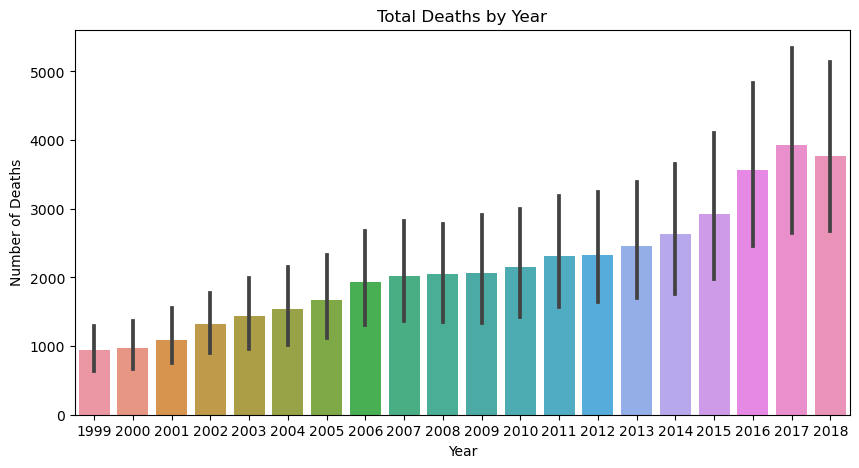

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.barplot(x='Year', y='Deaths', data=vdf)
plt.title('Total Deaths by Year')
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.show()

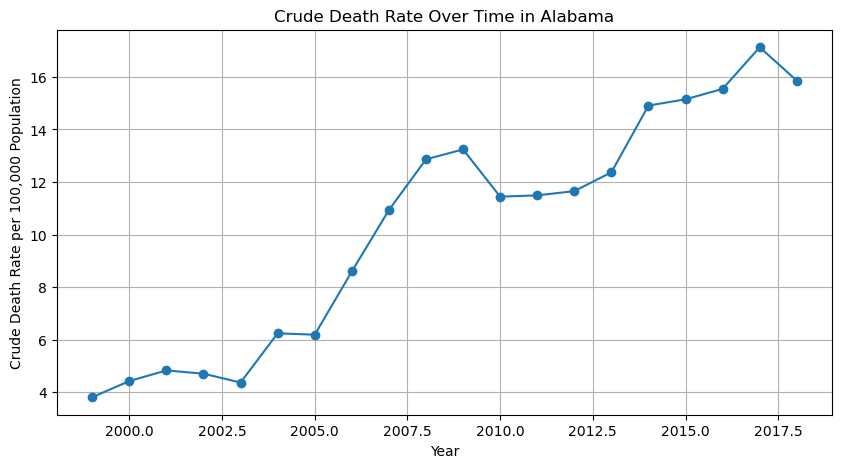

In [22]:
alabama_data = new_df[new_df['State'] == 'Alabama']
plt.figure(figsize=(10, 5))
plt.plot(alabama_data['Year'], alabama_data['Crude Death Rate'], marker='o')
plt.title('Crude Death Rate Over Time in Alabama')
plt.xlabel('Year')
plt.ylabel('Crude Death Rate per 100,000 Population')
plt.grid(True)
plt.show()

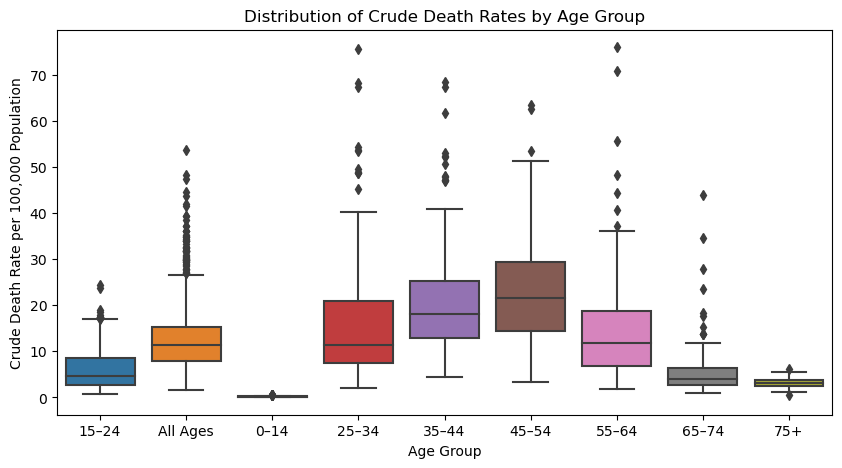

In [23]:

# Plotting
plt.figure(figsize=(10, 5))
sns.boxplot(x='Age Group', y='Crude Death Rate', data=vdf)
plt.title('Distribution of Crude Death Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Crude Death Rate per 100,000 Population')
plt.show()

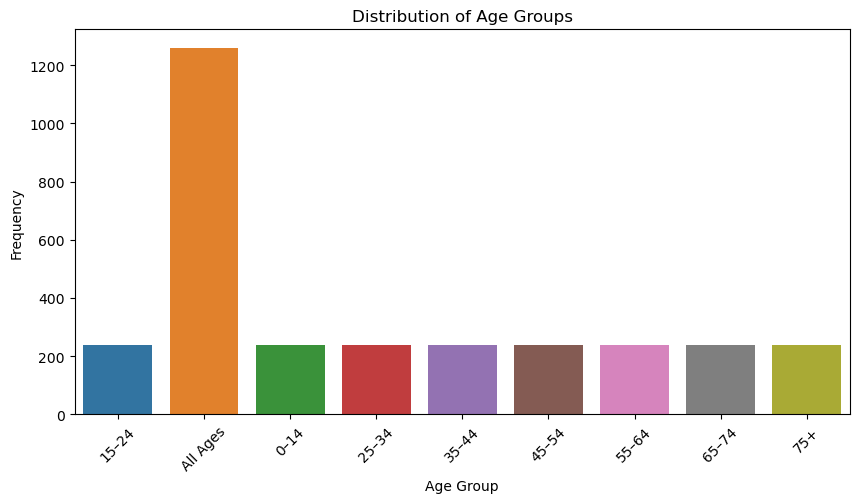

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Age Group', data=vdf)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [25]:
new_df.columns

Index(['State', 'Year', 'Sex', 'Age Group', 'Race and Hispanic Origin',
       'Deaths', 'Population', 'Crude Death Rate', 'Age-adjusted Rate',
       'US Crude Rate', 'US Age-adjusted Rate'],
      dtype='object')

In [26]:
new_df.isnull().sum()

State                          0
Year                           0
Sex                            0
Age Group                      0
Race and Hispanic Origin       0
Deaths                         0
Population                     0
Crude Death Rate               0
Age-adjusted Rate           1920
US Crude Rate                  0
US Age-adjusted Rate           0
dtype: int64

In [27]:
# Example feature selection
features = new_df[['Year','Deaths', 'Population','US Age-adjusted Rate' ]]# assuming numerical data is ready to use
target = new_df['Crude Death Rate']

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression
# Model setup
model = LinearRegression()
# Training the model
model.fit(X_train, y_train)

LinearRegression()

In [31]:
# Making predictions
y_pred_test = model.predict(X_test)
# Predicting
predictions = model.predict(X_test)

In [32]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluating the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

Mean Squared Error: 57.36508599423581
R-squared Score: 0.4328604467164783


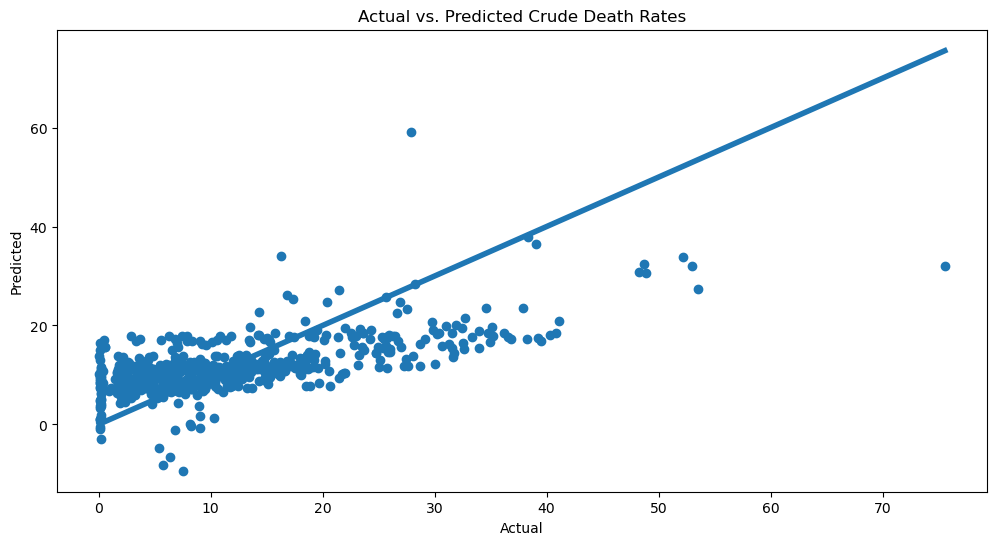

In [33]:
# Visualizing the Results of the Model
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=4)
plt.title('Actual vs. Predicted Crude Death Rates')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

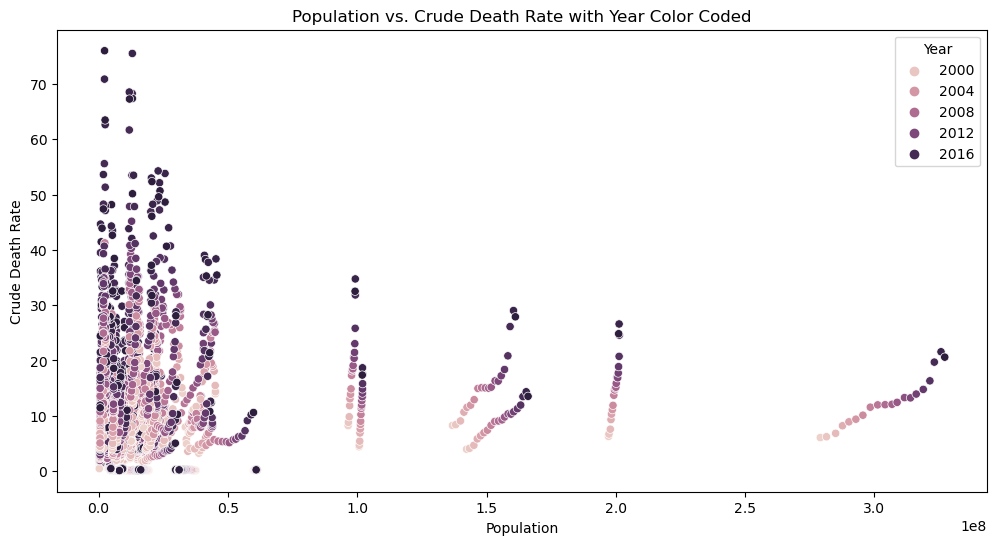

In [34]:
# Exploratory Data Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Population', y='Crude Death Rate', hue='Year', data=df)
plt.title('Population vs. Crude Death Rate with Year Color Coded')
plt.xlabel('Population')
plt.ylabel('Crude Death Rate')
plt.legend(title='Year')
plt.show()

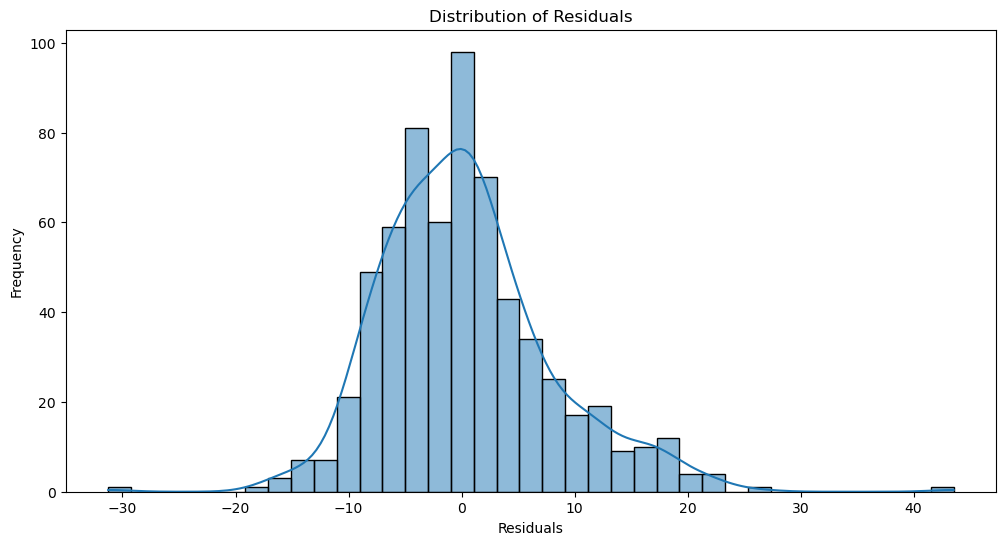

In [35]:
# Residuals Plot
residuals = y_test - predictions
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

### Data to be Dumped in postgresql

In [36]:
#First we have to convert all the dtype into str as postgresql does not accept the object dtype
new_df['Year'] = new_df['Year'].astype(str)
new_df['Deaths'] = new_df['Deaths'].astype(str)
new_df['Population'] = new_df['Population'].astype(str)
new_df['Crude Death Rate'] = new_df['Crude Death Rate'].astype(str)
new_df['US Crude Rate'] = new_df['US Crude Rate'].astype(str)
new_df['US Age-adjusted Rate'] = new_df['US Age-adjusted Rate'].astype(str)

In [37]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine

In [38]:
# Connection parameters for PostgreSQL
database = {
    "host": "localhost",
    "port": "5432",
    "user": "postgres",
    "password": "Mypassword07"
}

In [39]:
# Establish a connection to the PostgreSQL server
try:
    conn = psycopg2.connect(**database)
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    # Creating a cursor to perform database operations
    cur = conn.cursor()
    # Fisrt it will check if the 'DAP Project' database already exists,
    #if not it will create the database
    cur.execute("SELECT 1 FROM pg_database WHERE datname='DAP Project';")
    exists = cur.fetchone()
    if not exists:
        cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier('DAP Project')))
        print("Database 'DAP Project' was successfully created.")
    else:
        print("Database 'DAP Project' already exists. No action was taken.")
except psycopg2.Error as e:
    print("An error occurred: ", e)
finally:
    if cur:
        cur.close()
    if conn:
        conn.close()
print("Finished checking and potentially creating the 'DAP Poject database.")

Database 'DAP Project' already exists. No action was taken.
Finished checking and potentially creating the 'DAP Poject database.


In [40]:
# Create the database engine
# PostgreSQL connection parameters
username = 'postgres'
password = 'Mypassword07'
host = 'localhost'
port = '5432'
database = 'DAP Project'
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

In [41]:
#Finally our all connection setup is done and now by using the 'to_sql' will dump all the
#data in database
new_df.to_sql('NCHS', con=engine, index=False, if_exists='replace')

180